In [1]:
import tensorflow as tf
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from net.coarsenet import CoarseNet
%matplotlib inline

inp = tf.placeholder(tf.float32,shape=[None,224,224,4],name='input')
coarse_net = CoarseNet(inp,'resnet_v1_50',False)
net,end_points = coarse_net.net,coarse_net.end_points


# Attach sigmoid and reshape
coarse_out= tf.reshape(tf.sigmoid(net),[-1,56,56,1])
sess = tf.InteractiveSession()
global_step_var = tf.Variable(0, trainable=True)

coarse_net.initialize(sess,'exp/coarse-weighted-f5-5/iters-14000')
#saver = tf.train.Saver()
#saver.restore(sess, 'exp/coarse-weighted-f5-5/iters-11000')


print("Model Loaded")

INFO:tensorflow:Scale of 0 disables regularizer.


2016-10-12 22:25:17,492 - tensorflow - INFO - Scale of 0 disables regularizer.
Model Loaded


In [ ]:
from dataprovider.preprocess import vgg_preprocess
import os
from skimage import transform
BASE_DIR = os.path.join('/work/george','DAVIS')
IMAGESETS = os.path.join('ImageSets','480p')
    
RESIZE_HEIGHT = 224
RESIZE_WIDTH = 224

def read_image(imageFile,prevMaskFile):
        
    # Fix full file path
    rgbFile =BASE_DIR + imageFile
    maskFile = BASE_DIR + prevMaskFile
        
    # Read images 
    rgb = io.imread(rgbFile)
    mask = io.imread(maskFile,as_grey=True)
    mask = np.expand_dims(mask,axis=2)
        
    # Concatenate images
    image =  np.concatenate((rgb, mask), 2)
    
    # Resize 
    image = transform.resize(image,[RESIZE_HEIGHT,RESIZE_WIDTH])
       
    #io.imshow(image[:,:,0:3])  
    print('Max',image.max(),image.min())
    image = image*255
    #plt.imshow(image[:,:,0:3].astype(np.uint8)) 
    
    
    image = np.expand_dims(image,axis=0)
    
    image = vgg_preprocess(image)
    
    return image

def read_raw_image(image_file):
    fullfile_path = BASE_DIR + image_file
    image = io.imread(fullfile_path)
    # Resize 
    #image = transform.resize(image,[RESIZE_HEIGHT,RESIZE_WIDTH])
    return image
test_img = ['JPEGImages/480p/bear/00004.jpg' ,'Annotations/480p/bear/00003.png']
v = read_image(test_img[0],test_img[1])

In [3]:
import re
def get_mask_file_name(image_name):
    m=re.match(r"(/.*/.*/)(.*/.*).jpg",image_name)
    frame_no = m.group(2)
    return '/Annotations/480p/{}.png'.format(frame_no)

2016-10-12 22:25:24,072 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-12 22:25:24,073 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 2880
Max 1.0 0.0
2016-10-12 22:25:25,693 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-12 22:25:25,693 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 2862
2016-10-12 22:25:25,708 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-12 22:25:25,709 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3551
Max 1.0 0.0
2016-10-12 22:25:26,172 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-12 22:25:26,173 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3523
2016-10-12 22:25:26,189 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-12 22:25:26,190 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3129
Max 1.0 0.0
2016-10-12 22:25:26,657 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-12 22:25:26,658 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3155
2016-10-12 22:25:26,673 - PIL.PngImagePl

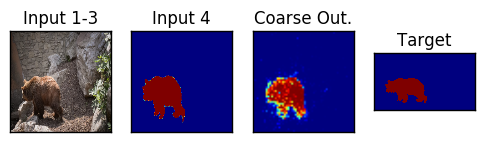

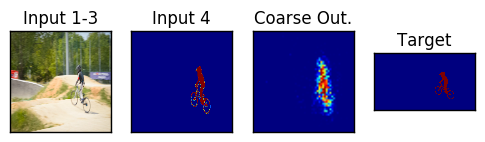

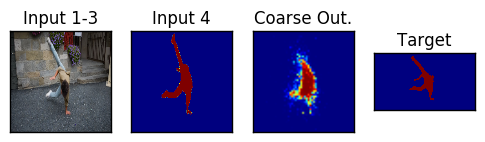

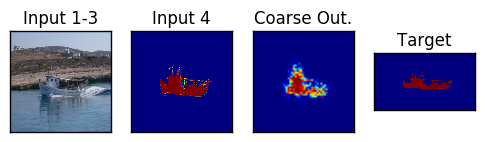

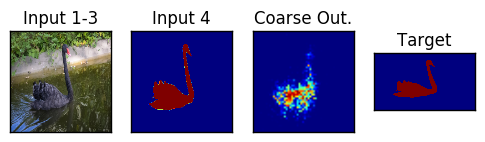

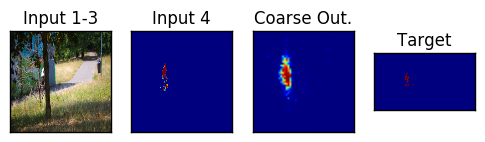

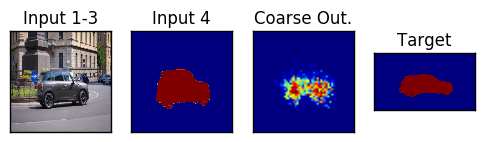

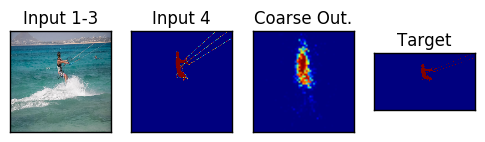

In [4]:
from skimage import morphology

img_list = [['/JPEGImages/480p/bear/00004.jpg' ,'/Annotations/480p/bear/00003.png'],
['/JPEGImages/480p/bmx-bumps/00086.jpg' ,'/Annotations/480p/bmx-bumps/00085.png'],
           ['/JPEGImages/480p/breakdance-flare/00003.jpg', '/Annotations/480p/breakdance-flare/00002.png'],
           ['/JPEGImages/480p/boat/00008.jpg','/Annotations/480p/boat/00007.png' ],
           ['/JPEGImages/480p/blackswan/00007.jpg', '/Annotations/480p/blackswan/00006.png' ],
           ['/JPEGImages/480p/bmx-trees/00066.jpg', '/Annotations/480p/bmx-trees/00065.png' ],
           ['/JPEGImages/480p/car-roundabout/00042.jpg', '/Annotations/480p/car-roundabout/00041.png' ],
           ['/JPEGImages/480p/kite-surf/00034.jpg', '/Annotations/480p/kite-surf/00033.png' ]]

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
_M_MEAN = 127

for image_no in range(len(img_list)):

    image = read_image(img_list[image_no][0],img_list[image_no][1])
    #image[0,:,:,3] = morphology.erosion(image[0,:,:,3],np.ones([3,3]))
    images = image
    for i in range(16):
       images = np.concatenate((images,image),0)
    
    result = sess.run([coarse_out],feed_dict={inp:images})


    plt.figure()


    #Plot input image
    plt.subplot(1,4,1)
    frame1 = plt.gca()
    frame1.axes.set_title('Input 1-3')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    rgb = image[0,:,:,0:3]
    #print(rgb.shape)
    means = [_R_MEAN, _G_MEAN ,_B_MEAN]
    rgb = rgb + means
    plt.imshow(rgb.astype(np.uint8))

    #Plot previous label
    plt.subplot(1,4,2)
    
    frame1 = plt.gca()
    frame1.axes.set_title('Input 4')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(image[0,:,:,3])

    #Plot output
    plt.subplot(1,4,3)
    frame1 = plt.gca()
    frame1.axes.set_title('Coarse Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(result[0][0,:,:,0])
    
    
    #Plot label
    plt.subplot(1,4,4)
    frame1 = plt.gca()
    frame1.axes.set_title('Target')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(read_raw_image(get_mask_file_name(img_list[image_no][0])))

In [ ]:
from skimage import morphology
import numpy as np

img_list = [['/JPEGImages/480p/bear/00004.jpg' ,'/Annotations/480p/bear/00003.png'],
['/JPEGImages/480p/bmx-bumps/00086.jpg' ,'/Annotations/480p/bmx-bumps/00085.png'],
           ['/JPEGImages/480p/breakdance-flare/00003.jpg', '/Annotations/480p/breakdance-flare/00002.png'],
           ['/JPEGImages/480p/boat/00008.jpg','/Annotations/480p/boat/00007.png' ],
           ['/JPEGImages/480p/blackswan/00007.jpg', '/Annotations/480p/blackswan/00006.png' ],
           ['/JPEGImages/480p/bmx-trees/00066.jpg', '/Annotations/480p/bmx-trees/00065.png' ],
           ['/JPEGImages/480p/car-roundabout/00042.jpg', '/Annotations/480p/car-roundabout/00041.png' ],
           ['/JPEGImages/480p/kite-surf/00034.jpg', '/Annotations/480p/kite-surf/00033.png' ]]

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
_M_MEAN = 127


image = read_image(img_list[1][0],img_list[1][1])
    #image[0,:,:,3] = morphology.erosion(image[0,:,:,3],np.ones([3,3]))

    #result = sess.run([coarse_out,refine_out],feed_dict={inp:image})
result0 = sess.run([coarse_out],feed_dict={inp:image})
result1 = sess.run([coarse_out],feed_dict={inp:image})

diff = result0[0][0,:,:,0] - result1[0][0,:,:,0]
print(np.amax(diff))

In [ ]:
from dataprovider.sampleinputprovider import SampleInputProvider

label =  tf.placeholder(tf.float32,shape=[None,224,224],name='label')
h_label = tf.expand_dims(label,3)        
label_resized = tf.image.resize_images(h_label,56,56)
label_reshaped = tf.reshape(label_resized,[-1,(56*56)]) 
loss_unweighted = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(net, label_reshaped))

inp_provider = SampleInputProvider(is_coarse = True,is_dummy = True)
next_batch = inp_provider.sequence_batch_itr(16)
for i, sequence_batch in enumerate(next_batch):
    result = sess.run([coarse_out,loss_unweighted],feed_dict={inp:sequence_batch.images,
                                              label:sequence_batch.labels})
    plt.figure()
    plt.imshow(result[0][0,:,:,0],cmap='Greys_r')
    print ('loss = {}'.format(result[1]))
            